In [2]:
import os
import sys
os.environ['XLA_FLAGS'] = f"--xla_force_host_platform_device_count={os.cpu_count()}"
sys.path.append('../')
from jax import config
config.update("jax_enable_x64", True)
import jax
from jax import vmap, jit, grad, random, jacfwd
from jax.lax import map
import jax.numpy as jnp
import numpy as np
import time
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm, colors
import warnings
import numpyro
numpyro.enable_x64()
from gwb.omega_gw_jax import OmegaGWjax
from interpolation.spline import Spline
from inference.numpyro_model import model
from inference.numpyro_infer import NumpyroInference
from getdist import plots,MCSamples,loadMCSamples
%config InlineBackend.figure_format = 'retina'
font = {'size'   : 16, 'family':'serif'}
axislabelfontsize='large'
matplotlib.rc('font', **font)
matplotlib.rc('text', usetex=True) # if using latex in plots
matplotlib.rc('legend', fontsize=16)


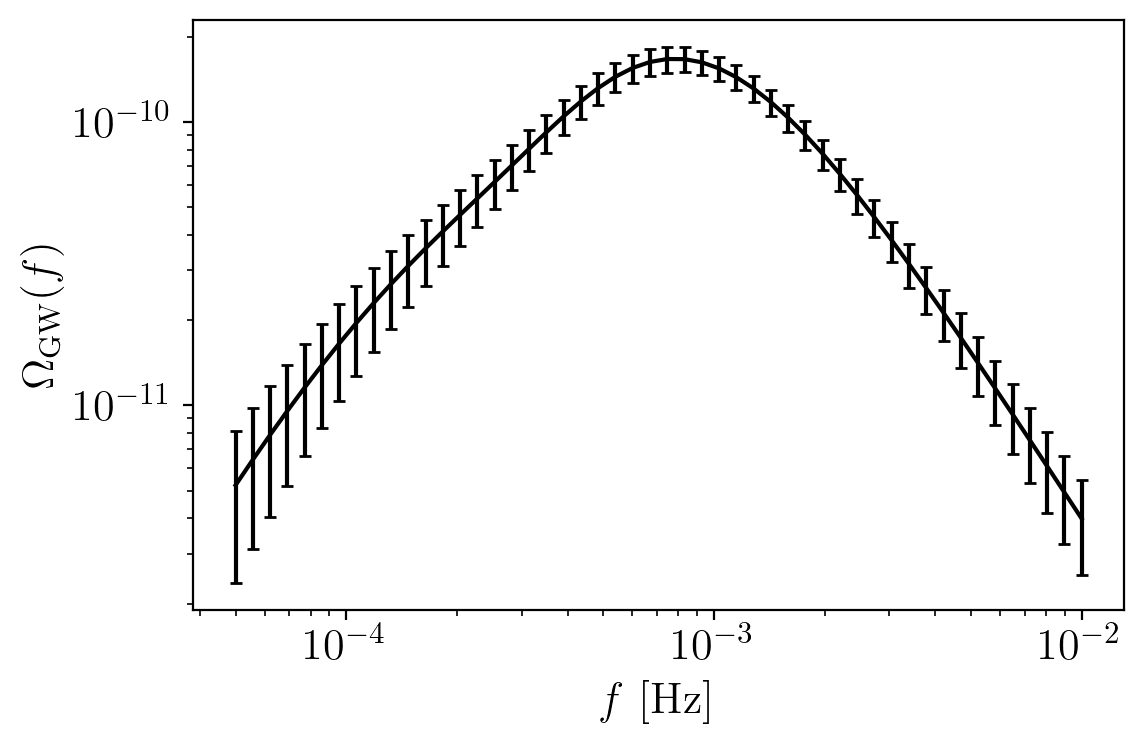

In [3]:
# load the gwb data from file and plot it
data = np.load('../bpl_data.npz')
frequencies = data['k']
Omegas = data['gw']
cov = data['cov']
p_arr = data['p_arr']
pz_amp = data['pz_amp']

plt.figure(figsize=(6,4))
plt.errorbar(frequencies, Omegas, yerr=np.sqrt(np.diag(cov)), fmt="", color='k', label='data',capsize=2,ecolor='k')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$f$ [Hz]')
plt.ylabel(r'$\Omega_{\rm GW}(f)$')
plt.tight_layout()

### Dynesty fixed nodes

In [8]:
s = jnp.linspace(0, 1, 15)  # First rescaled internal momentum
t = jnp.logspace(-5,5, 150)  # Second rescaled internal momentum
t_expanded = jnp.expand_dims(t, axis=-1)
## Repeat t along the new axis to match the shape (100, 1000)
t = jnp.repeat(t_expanded, len(frequencies), axis=-1)

gwb_calculator = OmegaGWjax(s=s,t=t,f=frequencies,norm="RD",jit=True)

num_nodes = 5
free_nodes = num_nodes - 2
pk_min, pk_max = min(p_arr), max(p_arr)
left_node, right_node = np.log10(pk_min), np.log10(pk_max)
nodes = jnp.linspace(left_node, right_node, num_nodes)
# interpolator = Spline(k_min=pk_min, k_max= pk_max,sample_nodes=False,fixed_nodes=None,num_nodes=num_nodes)
y_max = -6
y_min = -2


def prior_1D(cube):
    ys = cube.copy()
    ys = ys*(y_max - y_min) + y_min
    return ys

from interpax import CubicSpline
from functools import partial
# from jax import lax

# @jit
def interpolate(vals,x):
    # nodes = jnp.pad(nodes, (1,1), 'constant', constant_values=(left_node, right_node))
    spl = CubicSpline(nodes,vals,check=False)
    res = jnp.power(10,spl(x))
    res = jnp.where(x<left_node, 0, res)
    res = jnp.where(x>right_node, 0, res)
    return res

def get_gwb(vals):
    pf = lambda k: interpolate(vals,jnp.log10(k))
    omegagw = gwb_calculator(pf,frequencies)
    return omegagw

get_gwb_func = jax.jit(get_gwb)

def likelihood(params):
    # print(params)
    omegagw = get_gwb_func(params)
    diff = omegagw - Omegas
    res = -0.5 * np.dot(diff, np.linalg.solve(cov,diff))
    res = np.where(np.isnan(res),-1e10, res)
    res = np.where(res<-1e10,-1e10, res)
    return res

from dynesty import NestedSampler

ndim = num_nodes
# use 25*dim as live points or 300, whichever is larger
sampler = NestedSampler(likelihood, prior_1D, ndim, sample='rslice')
sampler.run_nested(dlogz=0.01)
results = sampler.results
results.summary()

10188it [1:19:59,  2.12it/s, +500 | bound: 45 | nc: 1 | ncall: 378938 | eff(%):  2.824 | loglstar:   -inf < -2.386 <    inf | logz: -18.133 +/-  0.163 | dlogz:  0.000 >  0.010]

Summary
nlive: 500
niter: 10188
ncall: 378438
eff(%):  2.824
logz: -18.133 +/-  0.167


#### Dynesty free nodes

In [5]:
s = jnp.linspace(0, 1, 15)  # First rescaled internal momentum
t = jnp.logspace(-5,5, 150)  # Second rescaled internal momentum
t_expanded = jnp.expand_dims(t, axis=-1)
## Repeat t along the new axis to match the shape (100, 1000)
t = jnp.repeat(t_expanded, len(frequencies), axis=-1)

gwb_calculator = OmegaGWjax(s=s,t=t,f=frequencies,norm="RD",jit=True)

num_nodes = 5
free_nodes = num_nodes - 2
pk_min, pk_max = min(p_arr), max(p_arr)
left_node, right_node = np.log10(pk_min), np.log10(pk_max)
# interpolator = Spline(k_min=pk_min, k_max= pk_max,sample_nodes=False,fixed_nodes=None,num_nodes=num_nodes)
y_max = -6
y_min = -2

def prior_1D(cube):
    # Order and transform nodes to be in the correct range, from Polychord SortedUniformPrior
    # params = np.atleast_2d(cube.copy())
    params = cube.copy()
    x = params[:free_nodes]
    # x = params[:,:free_nodes]
    # Npoints = cube.shape[0]
    N = free_nodes
    t = np.zeros(N)
    t[N-1] = x[N-1]**(1./N)
    for n in range(N-2, -1, -1):
        t[n] = x[n]**(1./(n+1)) * t[n+1]
    xs = t*(right_node - left_node) + left_node
    ys = params[free_nodes:]
    ys = ys*(y_max - y_min) + y_min
    return np.concatenate([xs,ys]) # array

def prior(cube):
    """
    Transforms the input cube from [0,1] uniform parameters to the desired prior space.
    This vectorized version supports cube being either a 1D array of shape (nd,)
    or a 2D array of shape (Npoints, nd).
    
    The cube is assumed to be structured as follows:
      - The first 'free_nodes' values correspond to the x parameters.
      - The remaining values correspond to the y parameters.
    
    Global variables used:
      free_nodes: int, number of nodes for the x parameters (also called N)
      left_node, right_node: floats defining the transformation range for x.
      y_min, y_max: floats defining the transformation range for y.
    """
    # Ensure cube is at least 2D (1D arrays are treated as a single row)
    cube = np.atleast_2d(cube.copy())
    
    N = free_nodes  # Number of x parameters
    # Extract x parameters (shape: (Npoints, free_nodes))
    x = cube[:, :N]
    
    # Create an array of exponents: 1/(1), 1/(2), ..., 1/(N)
    exponents = 1.0 / np.arange(1, N+1)
    # Raise x to the corresponding exponents, broadcasting over the rows
    # This gives an array 'y' of shape (Npoints, free_nodes)
    y = x ** exponents
    
    # Compute the reverse cumulative product along the second axis.
    # Step 1: Reverse the order of columns.
    # Step 2: Compute cumulative product along axis=1.
    # Step 3: Reverse the result back.
    t = np.cumprod(y[:, ::-1], axis=1)[:, ::-1]
    
    # Transform the cumulative product to the desired x space.
    xs = t * (right_node - left_node) + left_node
    
    # Process the y parameters (the remaining columns)
    ys = cube[:, N:]
    ys = ys * (y_max - y_min) + y_min
    
    # Concatenate the transformed x and y parameters along the second axis.
    return np.concatenate([xs, ys], axis=1)

from interpax import CubicSpline
from functools import partial
# from jax import lax

# def check_bounds(x):
#     # if x out of bounds return 0
#     lax.cond()

# @jit
def interpolate(nodes,vals,x):
    # nodes = jnp.pad(nodes, (1,1), 'constant', constant_values=(left_node, right_node))
    spl = CubicSpline(nodes,vals,check=False)
    res = jnp.power(10,spl(x))
    res = jnp.where(x<left_node, 0, res)
    res = jnp.where(x>right_node, 0, res)
    return res

def get_gwb(nodes,vals):
    pf = lambda k: interpolate(nodes,vals,jnp.log10(k))
    omegagw = gwb_calculator(pf,frequencies)
    return omegagw

get_gwb_func = jax.jit(get_gwb)

def likelihood(params):
    # print(params)
    nodes = params[:free_nodes]
    # print(nodes)
    nodes = jnp.pad(nodes,(1,1), 'constant', constant_values=(left_node, right_node))
    # print(nodes)
    vals = params[free_nodes:]
    omegagw = get_gwb_func(nodes,vals)
    diff = omegagw - Omegas
    res = -0.5 * np.dot(diff, np.linalg.solve(cov,diff))
    res = np.where(np.isnan(res),-1e10, res)
    res = np.where(res<-1e10,-1e10, res)
    return res

from dynesty import NestedSampler


ndim = free_nodes + num_nodes
# use 25*dim as live points or 300, whichever is larger
sampler = NestedSampler(likelihood, prior_1D, ndim, sample='rslice')
sampler.run_nested(dlogz=0.01)
results = sampler.results
results.summary()

2000it [09:13,  1.00it/s, bound: 3 | nc: 60 | ncall: 39188 | eff(%):  5.104 | loglstar:   -inf < -565.251 <    inf | logz: -575.056 +/-    nan | dlogz: 554.879 >  0.010]     Traceback (most recent call last):
  File "/opt/homebrew/Caskroom/miniforge/base/envs/cosmo/lib/python3.12/site-packages/dynesty/dynesty.py", line 910, in __call__
    return self.func(np.asarray(x).copy(), *self.args, **self.kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/sq/_30b3rn56vz_g8gd5ts_jzf40000gn/T/ipykernel_3329/2190624663.py", line 111, in likelihood
    res = -0.5 * np.dot(diff, np.linalg.solve(cov,diff))
                              ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/homebrew/Caskroom/miniforge/base/envs/cosmo/lib/python3.12/site-packages/numpy/linalg/linalg.py", line 397, in solve
    b, wrap = _makearray(b)
              ^^^^^^^^^^^^^
  File "/opt/homebrew/Caskroom/miniforge/base/envs/cosmo/lib/python3.12/site-packages/numpy/linalg/linalg.py", 

Exception while calling loglikelihood function:
  params: [-4.52354779 -2.78626517 -1.48598768 -3.3696637  -4.93026881 -2.59810672
 -5.83775316 -3.82584995]
  args: []
  kwargs: {}
  exception:


KeyboardInterrupt: 

In [23]:
samples, logl, logwt = sampler.posterior()

print(samples.shape)
print(logl.shape)
print(logwt.shape)

import math
SQRTEPS = math.sqrt(float(np.finfo(np.float64).eps))
def resample_equal(samples,logl, logwt, rstate):
    # Extract the weights and compute the cumulative sum.
    wt = np.exp(logwt)
    weights = wt / wt.sum()
    cumulative_sum = np.cumsum(weights)

    # if abs(cumulative_sum[-1] - 1.) > SQRTEPS:
    #     # same tol as in numpy's random.choice.
    #     # Guarantee that the weights will sum to 1.
    #     warnings.warn("Weights do not sum to 1 and have been renormalized.")
    cumulative_sum /= cumulative_sum[-1]
    # this ensures that the last element is strictly == 1

    # Make N subdivisions and choose positions with a consistent random offset.
    nsamples = len(weights)
    print(nsamples)

    positions = (rstate.random() + np.arange(nsamples)) / nsamples

    # Resample the data.
    idx = np.zeros(nsamples, dtype=int)
    i, j = 0, 0
    while i < nsamples:
        if positions[i] < cumulative_sum[j]:
            idx[i] = j
            i += 1
        else:
            j += 1
    
    perm = rstate.permutation(nsamples)
    resampled_samples = samples[idx][perm]
    resampled_logl = logl[idx][perm]
    return resampled_samples, resampled_logl

rstate = np.random.default_rng(100000)
samples, lp = resample_equal(samples,logl,logwt, rstate=rstate)

print("Obtained equally weighted samples")
print(f"Max and min logprob: {np.max(lp)}, {np.min(lp)}")
print(len(lp))

# samples = samples[lp>-10,:]

(165600, 8)
(165600,)
(165600,)
165600
Obtained equally weighted samples
Max and min logprob: -5.8154585743203775, -16.38487008207096
165600


In [ ]:
p_arr = np.geomspace(pk_min*1.001,pk_max*0.999,100,endpoint=True)

ys = samples[:,free_nodes:]
xs = samples[:,:free_nodes]
print(len(samples))
thinning = len(samples) // 64
print(thinning)
cmap = matplotlib.colormaps['Reds']
ys = ys[::thinning]
xs = xs[::thinning]
lp = lp[::thinning] 
lp_min, lp_max = np.min(lp), np.max(lp)
print(lp_min, lp_max)
cols = (lp-lp_min)/(lp_max - lp_min) # normalise the logprob to a colour

# print(cols)
norm = colors.Normalize(lp_min,lp_max)

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,4),layout='constrained')

def get_pz_omega(x,y):
    pf = lambda k: interpolate(x, y , jnp.log10(k))
    pz_amps = pf(p_arr)
    gwb_res = gwb_calculator(pf,  frequencies)
    return pz_amps, gwb_res

for i,y in enumerate(ys):
    x = jnp.pad(xs[i], (1,1), 'constant', constant_values=(left_node, right_node) )
    pz_amps, gwb_amps = get_pz_omega(x,y)
    ax1.loglog(p_arr,pz_amps,alpha=0.25,color=cmap(cols[i]))
    ax1.scatter(10**(x),10**(ys[i]),s=16,alpha=0.5,color=cmap(cols[i]))
    ax2.loglog(frequencies,gwb_amps,alpha=0.25,color=cmap(cols[i]))

# pz_amp = test_pz(p_arr)
ax1.loglog(p_arr,pz_amp,color='k',lw=1.5)

ax2.loglog(frequencies,Omegas,color='k',lw=1.5,label='Truth')

ax2.legend()
ax1.set_ylabel(r'$P_{\zeta}(k)$')
ax1.set_xlabel(r'$k$')
ax2.errorbar(frequencies, Omegas, yerr=np.sqrt(np.diag(cov)), fmt="", color='k', label='data',capsize=2,ecolor='k')

ax2.set_ylabel(r'$\Omega_{\mathrm{GW}}(k)$')
ax2.set_xlabel(r'$k$')
fig.colorbar(cm.ScalarMappable(norm=norm,cmap=cmap),ax=[ax1,ax2],label='Logprob')

165600
2587
-13.169507578974205 -9.250521000308446


Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x105fed760>>
Traceback (most recent call last):
  File "/opt/homebrew/Caskroom/miniforge/base/envs/cosmo/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 770, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 


(2070, 100)
(2070, 50)


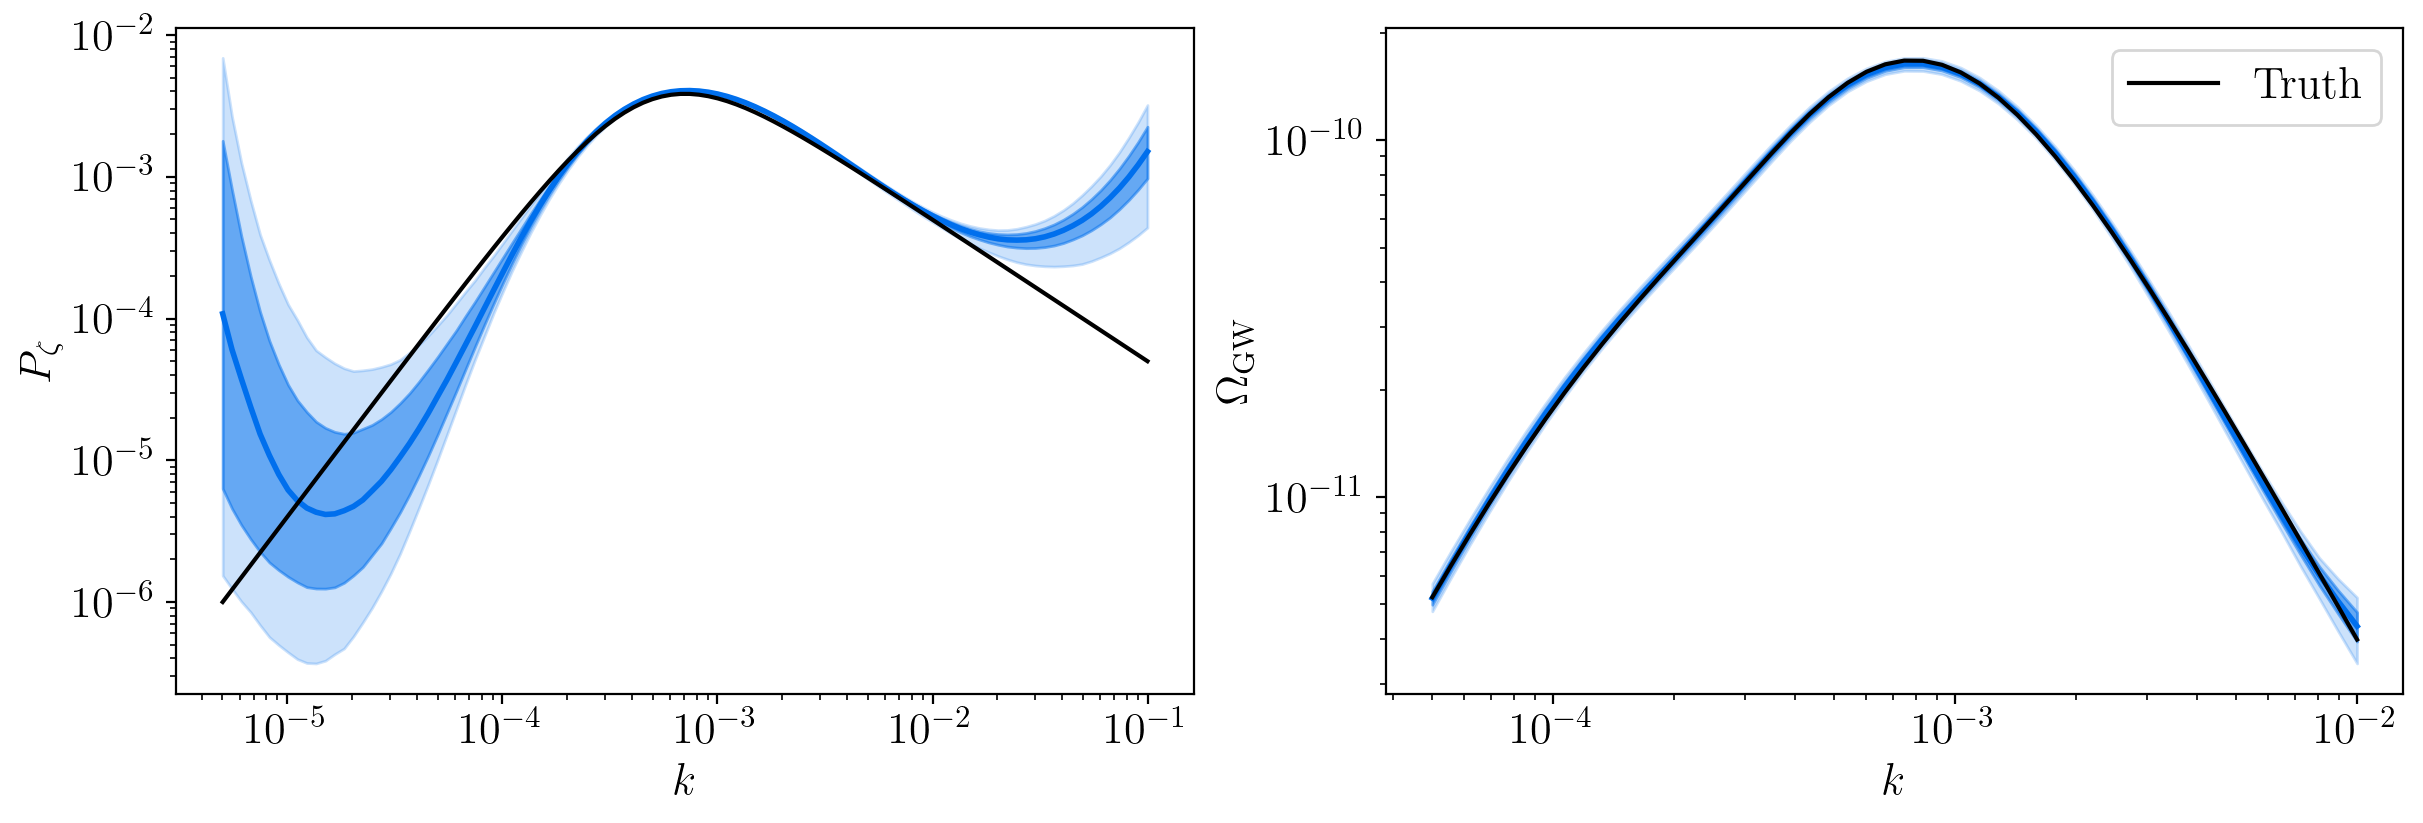

In [22]:
# Plot the functional posterior

# print(len(samples['values']))



def plot_functional_posterior(vals = [],k_arr = [], intervals = [95.,68.],ylabels=[r'$P_{\zeta}$',r'$\Omega_{\rm GW}$'],aspect_ratio = (6,4), interval_cols = [('#006FED',0.2),('#006FED',0.5)]):
    # given a function y = f(k|x) with x~Posterior samples, plot the posterior of y at k_arr, with symmetric credible intervals

    nfuncs = len(vals)

    fig, ax = plt.subplots(1,nfuncs,figsize=(aspect_ratio[0]*nfuncs,aspect_ratio[1]),constrained_layout=True)
    if nfuncs == 1:
        ax = [ax]
    for i,val in enumerate(vals):
        for j,interval in enumerate(intervals):
            y_low, y_high = np.percentile(val,[50-interval/2,50+interval/2],axis=0)
            ax[i].fill_between(k_arr[i],y_low,y_high,color=interval_cols[j])
        ax[i].plot(k_arr[i],np.median(val,axis=0),color='#006FED',lw=2)
        ax[i].set_ylabel(ylabels[i])
    for x in ax:
        x.set(xscale='log',yscale='log',xlabel=r'$k$')
    return fig, ax 


gd_colors = ['#006FED', '#E03424']

def get_pz_omega(nodes,vals):
    pf = lambda k: interpolate(nodes,vals,jnp.log10(k))
    pz_amps = pf(p_arr)
    gwb_res = gwb_calculator(pf,frequencies)
    return (pz_amps, gwb_res)

thinning = samples.shape[0] // 2048
xs, ys = samples[:,:free_nodes][::thinning], samples[:,free_nodes:][::thinning]
# pz_amps,gwb_amps = vmap(get_pz_omega)(xs,ys)

xs = jnp.pad(xs, ((0,0),(1,1)), 'constant', constant_values=((0,0),(left_node, right_node)))
ys = jnp.array(ys)
pz_amps,gwb_amps = split_vmap(get_pz_omega,(xs,ys),batch_size=32)


print(pz_amps.shape)
print(gwb_amps.shape)

# colors = 

fig, ax = plot_functional_posterior([pz_amps,gwb_amps],k_arr=[p_arr,frequencies],aspect_ratio=(6,4))
ax[0].loglog(p_arr,pz_amp,color='k',lw=1.5)
ax[1].loglog(frequencies,Omegas,color='k',lw=1.5,label='Truth')
ax[1].legend()
# ax[1].errorbar(frequencies, Omegas, yerr=np.sqrt(np.diag(cov)), fmt="", color='k', label='data',capsize=2,ecolor='k')


